In [0]:
import gdown
import os
from pandas_profiling import ProfileReport

# https://drive.google.com/file/d/1l_J0P9A_AD8d_rzZHJ5Fg8F4y1nGP_x3/view?usp=sharing

url = f'https://drive.google.com/uc?id=1l_J0P9A_AD8d_rzZHJ5Fg8F4y1nGP_x3'
filename = 'dataset.csv'
if not os.path.exists(filename):
    gdown.download(url, filename, quiet=True)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
columns = ['emotion', 'text']

df = pd.read_csv(filename, names=columns)

In [0]:
Xraw = df['text'].values
yraw = df['emotion'].values

### Preprocessing

In [95]:
import nltk

nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [96]:
!pip install autocorrect

In [0]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from autocorrect import Speller

spell = Speller(lang='en')

import re

def process_text(text):
    text = text if type(text) == str else ''

    # clean the words, remove symbols special chars
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)

    # convert to lowercase
    text = text.lower()

    # first tokenize the text
    word_tokenized = word_tokenize(text)

    # let's remove the stop words
    en_stopwords = stopwords.words('english')
    words_swords_removed = [spell(word) for word in word_tokenized if word not in en_stopwords]

    return words_swords_removed

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
cvector = CountVectorizer(tokenizer=process_text)

In [0]:
X_tr = cvector.fit_transform(Xraw)

In [120]:
X_tr

<7446x8686 sparse matrix of type '<class 'numpy.int64'>'
	with 70234 stored elements in Compressed Sparse Row format>

In [121]:
help(X_tr)

Help on csr_matrix in module scipy.sparse.csr object:

class csr_matrix(scipy.sparse.compressed._cs_matrix)
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indptr[i]:indptr[i+1]]`` and their
 |          corresponding values are stored in ``data[indptr[i]:

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
label_encoder = LabelEncoder()

In [124]:
label_encoder.fit(yraw)

LabelEncoder()

In [125]:
label_encoder.classes_

array(['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'],
      dtype=object)

In [126]:
y_tr = label_encoder.transform(yraw)
y_tr

array([4, 2, 0, ..., 1, 6, 3])

In [127]:
y_tr.shape

(7446,)

### Naive bayes classifier

In [0]:
from sklearn.naive_bayes import MultinomialNB

In [0]:
from sklearn.model_selection import train_test_split

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.3, shuffle=True)

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

X_train: (5212, 8686), X_test: (2234, 8686), y_train: (5212,), y_test: (2234,)


[750 736 726 730 759 756 755]
[319 323 337 310 323 318 304]


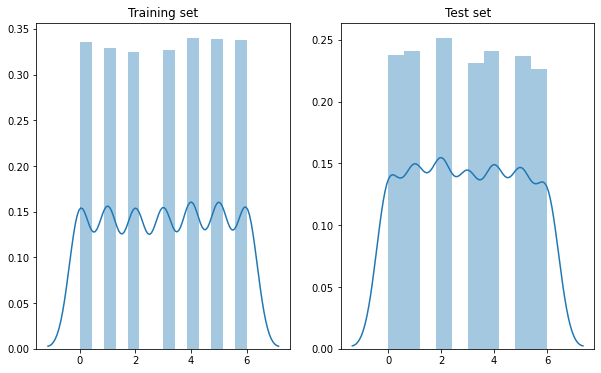

In [136]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.distplot(y_train)
plt.title('Training set')

plt.subplot(1, 2, 2)
sns.distplot(y_test)
plt.title('Test set')
print(np.bincount(y_train))
print(np.bincount(y_test))

The distribution of training set and test set seems similar.

In [137]:
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_train_pred = multi_nb.predict(X_train)
y_test_pred = multi_nb.predict(X_test)

In [139]:
from sklearn.metrics import classification_report

print('-' * 10 + ' Training Set ' + '-' * 10)
print(classification_report(y_train, y_train_pred))

print('-' * 10 + ' Testing Set ' + '-' * 10)
print(classification_report(y_test, y_test_pred))

---------- Training Set ----------
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       750
           1       0.88      0.80      0.84       736
           2       0.85      0.84      0.85       726
           3       0.78      0.79      0.79       730
           4       0.82      0.86      0.84       759
           5       0.83      0.83      0.83       756
           6       0.80      0.82      0.81       755

    accuracy                           0.82      5212
   macro avg       0.82      0.82      0.82      5212
weighted avg       0.82      0.82      0.82      5212

---------- Testing Set ----------
              precision    recall  f1-score   support

           0       0.43      0.44      0.44       319
           1       0.66      0.55      0.60       323
           2       0.68      0.63      0.66       337
           3       0.46      0.50      0.48       310
           4       0.64      0.69      0.67       323
         

With a simple naive bayes classifier, we have got an accuracy of $81\%$ on training set but just $56\%$ accuracy on the test set. We have to try other models or improve this for better accuracy for using baseline model.